In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import itertools 

In [5]:
import dolphindb
sess = dolphindb.session()
sess.connect("localhost", 8868, "admin", "123456")
print('DolphinDB available tables:')
sess.run('getClusterDFSTables()')

True

DolphinDB available tables:


array(['dfs://dailyETF/dailyETF', 'dfs://dailyOptions/dailyOptionsBasic',
       'dfs://dailyStock/dailyStockBasic',
       'dfs://dailyStock/dailyStockCapitalReduction',
       'dfs://dailyStock/dailyStockCompanies',
       'dfs://dailyStock/dailyStockDealers',
       'dfs://dailyStock/dailyStockForeign',
       'dfs://dailyStock/dailyStockForeignShare',
       'dfs://dailyStock/dailyStockMargin',
       'dfs://dailyStock/dailyStockRightDividend',
       'dfs://dailyStock/dailyStockRightDividendComp',
       'dfs://dailyStock/dailyStockShortSale',
       'dfs://dailyStock/dailyStockShortSaleBalance',
       'dfs://dailyStock/dailyStockShortSaleVolume',
       'dfs://dailyStock/dailyStockTradeDay',
       'dfs://daily_stock/dailyStock',
       'dfs://daily_stock_margin/dailyStockMargin',
       'dfs://daily_tfe/tickTFE', 'dfs://feature/indicator',
       'dfs://futTaifex/futTaifex',
       'dfs://test_indicator_tfe/testIndicator'], dtype='<U44')

In [6]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [7]:
import config as cfg

In [20]:
#TODO: switch to ddb twse index 
twse = pd.read_msgpack('/data/dataset/twse.msgpack')
twse.head()

/home/cyyen/miniconda3/envs/stock_path_tracker/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


,open,high,low,close,order_buy,order_sell,volume
date,,,,,,,
2005-07-11,6255.40,6305.61,6249.41,6298.86,88271.0,98780.0,93877.0
2005-07-12,6337.50,6365.76,6337.50,6358.81,86565.0,111912.0,101703.0
2005-07-13,6360.60,6406.99,6352.21,6377.09,80802.0,120531.0,106134.0
2005-07-14,6403.08,6427.32,6375.75,6418.35,92496.0,114781.0,106806.0
2005-07-15,6428.44,6454.33,6410.59,6410.59,88827.0,124306.0,106727.0


# quantization: 2012-11-22 ~ 2020-04-15
- TODO: add maturity dates before December 2012
- size of cell: 100 
- rounding: take floor

In [21]:
df = twse[cfg.D_START:][['close']].copy()

In [22]:
df['prc_qtz'] = df.close // cfg.SIZE_CELL * cfg.SIZE_CELL
df['delta'] = df.prc_qtz.diff()

In [23]:
settlements = pd.to_datetime(pd.read_csv('settlement_txf.csv').settlement).dt.date.tolist()
df['maturity'] = df.index.where(df.index.isin(settlements)).to_series().fillna(method='bfill').values
d2m = df.groupby('maturity').size().sort_index().tolist()
df['d2m'] = sum([list(reversed(range(d))) for d in d2m], []) + [np.nan] * (df.shape[0] - sum(d2m))
df = df[cfg.D_START: cfg.D_END]

df.dropna(inplace=True)
df.sort_index(ascending=True, inplace=True)

In [24]:
# vis
df[['close', 'prc_qtz', 'delta', 'd2m']].info()
df[['close', 'prc_qtz', 'delta', 'd2m']].head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 entries, 2012-11-23 to 2020-04-15
Data columns (total 4 columns):
close      1803 non-null float64
prc_qtz    1803 non-null float64
delta      1803 non-null float64
d2m        1803 non-null float64
dtypes: float64(4)
memory usage: 70.4 KB


,close,prc_qtz,delta,d2m
date,,,,
2012-11-23,7326.01,7300.0,200.0,18.0
2012-11-26,7407.37,7400.0,100.0,17.0
2012-11-27,7430.20,7400.0,0.0,16.0
2012-11-28,7434.93,7400.0,0.0,15.0
2012-11-29,7503.55,7500.0,100.0,14.0
2012-11-30,7580.17,7500.0,0.0,13.0
2012-12-03,7599.91,7500.0,0.0,12.0
2012-12-04,7600.98,7600.0,100.0,11.0
2012-12-05,7649.05,7600.0,0.0,10.0


## example: 2015-07-01 ~ 2015-07-14

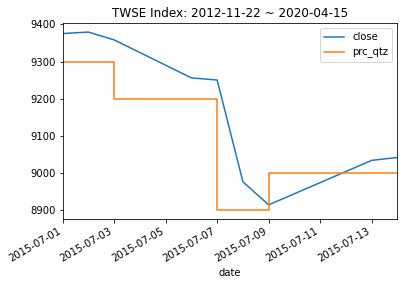

In [25]:
# vis
df_plot = df['2015-07-01': '2015-07-14' ]
ax = df_plot[['close']].plot(title=f'TWSE Index: {cfg.D_START} ~ {cfg.D_END}')
df_plot[['prc_qtz']].plot(drawstyle='steps', ax=ax)

# Distribution of changes in cell

## histogram 

Text(0.5, 1.0, '#(cells)')

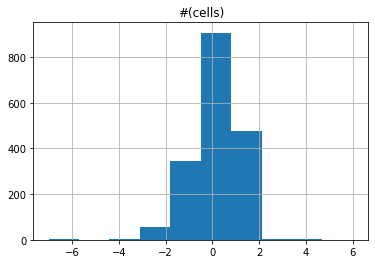

In [26]:
ax = df.delta.div(cfg.SIZE_CELL).hist()
ax.set_title('#(cells)')

## quantile

In [27]:
df_quantile = df.delta.div(cfg.SIZE_CELL).quantile([0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]).to_frame('delta').T
df_quantile.columns = ['min', "2.5%", '25%', 'median', '75%', '97.5%', 'max']
df_quantile

,min,2.5%,25%,median,75%,97.5%,max
delta,-7.0,-2.0,0.0,0.0,1.0,1.0,6.0


## extreme cases

In [28]:
df_extreme_pos = df.query(f'(delta > 2*{cfg.SIZE_CELL})')
df_extreme_pos.sort_index()

,close,prc_qtz,delta,maturity,d2m
date,,,,,
2018-02-21,10714.44,10700.0,300.0,2018-02-21,0.0
2018-10-31,9802.13,9800.0,300.0,2018-11-21,15.0
2018-12-03,10137.87,10100.0,300.0,2018-12-19,12.0
2020-03-20,9234.09,9200.0,600.0,2020-04-15,16.0
2020-03-24,9285.62,9200.0,400.0,2020-04-15,14.0
2020-03-25,9644.75,9600.0,400.0,2020-04-15,13.0
2020-04-14,10332.94,10300.0,300.0,2020-04-15,1.0


In [29]:
df_extreme_neg = df.query(f'(delta < -2*{cfg.SIZE_CELL})')
df_extreme_neg.sort_index()

,close,prc_qtz,delta,maturity,d2m
date,,,,,
2015-07-08,8976.11,8900.0,-300.0,2015-07-15,4.0
2015-08-21,7786.92,7700.0,-300.0,2015-09-16,18.0
2015-08-24,7410.34,7400.0,-300.0,2015-09-16,17.0
2016-11-09,8943.20,8900.0,-300.0,2016-11-16,5.0
2018-02-06,10404.00,10400.0,-500.0,2018-02-21,5.0
2018-10-11,9806.11,9800.0,-600.0,2018-10-17,4.0
2018-12-06,9684.72,9600.0,-300.0,2018-12-19,9.0
2020-01-30,11421.74,11400.0,-700.0,2020-02-19,14.0
2020-03-09,10977.64,10900.0,-400.0,2020-03-18,7.0


# compute joint probabilty

In [30]:
# winsorizing
df['delta_cell'] = df.delta // cfg.SIZE_CELL
df.loc[df.delta_cell >= cfg.MAX_DELTA_CELL, 'delta_cell'] = cfg.MAX_DELTA_CELL
df.loc[df.delta_cell <= - cfg.MAX_DELTA_CELL , 'delta_cell'] = - cfg.MAX_DELTA_CELL

In [33]:
def get_prob_single_day(df):
    prob_delta_cell = pd.Series(np.nan, index=range(-cfg.MAX_DELTA_CELL, cfg.MAX_DELTA_CELL+1))
    prob_delta_cell.update(df.groupby('delta_cell').size().div(df.shape[0]))
    prob_delta_cell.fillna(0, inplace=True)
    return prob_delta_cell
prob_delta_cell = get_prob_single_day(df)
prob_delta_cell.to_frame('prob').T

,-2,-1,0,1,2
prob,0.036606,0.191348,0.50305,0.244592,0.024404


Text(0.5, 1.0, 'Prob($\\Delta_t$)')

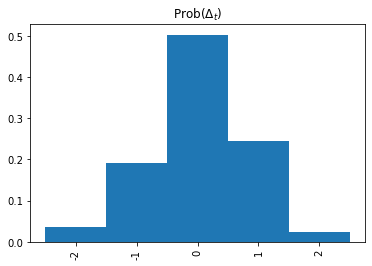

In [34]:
ax = prob_delta_cell.plot.bar(width=1)
ax.set_title('Prob($\Delta_t$)')

In [35]:
GB = 10**9
n_layer = 14
print(f'[{n_layer} days] used {sys.getsizeof(list(range(n_layer))) * 5**n_layer / GB:.2f} GB')

n_layer = 10
print(f'[{n_layer} days] used {sys.getsizeof(list(range(n_layer))) * 5**n_layer / GB:.2f} GB')

[14 days] used 1025.39 GB
[10 days] used 1.33 GB


- currently only calcualte for $\tau \leq 9$, because of huge computing demand and memory

In [39]:
gen_sequence = lambda var_tau: itertools.product(range(-cfg.MAX_DELTA_CELL, cfg.MAX_DELTA_CELL+1), repeat=var_tau+1)

def get_realizations(var_lambda, var_tau):
    assert var_tau <= 9, 'the probability matrix is not prepared for var_tau > 9'
    all_feasible_seqs = filter(lambda seq: sum(seq) == var_lambda, gen_sequence(var_tau))
    df_real = pd.DataFrame(list(all_feasible_seqs))
    df_real.index.name = 'realization'
    df_real.columns.name = 'duration'
    return df_real

def get_prob(df_real, prob_delta_cell):
    prob = df_real.replace(prob_delta_cell.to_dict()).product(axis=1).sum()
    return prob

In [40]:
var_lambda, var_tau = 2, 8
df_real = get_realizations(var_lambda, var_tau)
df_real['$\Sigma\Delta_t$'] = df_real.sum(axis=1)
df_real['prob'] = df_real.replace(prob_delta_cell.to_dict()).product(axis=1)
prob = get_realizations(var_lambda, var_tau).pipe(get_prob, prob_delta_cell)
print(f'''
lambda \t\t: \t {var_lambda}
tau \t\t: \t {var_tau}
#(realization) \t: \t {df_real.shape[0]}
probability \t: \t {prob*100:.2f} %
''')
df_real.head(10)


lambda 		: 	 2
tau 		: 	 8
#(realization) 	: 	 162585
probability 	: 	 12.84 %



duration,0,1,2,3,4,5,6,7,8,$\Sigma\Delta_t$,prob
realization,,,,,,,,,,,
0,-2,-2,-2,-2,2,2,2,2,2,2,3.792578e-16
1,-2,-2,-2,-1,1,2,2,2,2,2,1.986990e-14
2,-2,-2,-2,-1,2,1,2,2,2,2,1.986990e-14
3,-2,-2,-2,-1,2,2,1,2,2,2,1.986990e-14
4,-2,-2,-2,-1,2,2,2,1,2,2,1.986990e-14
5,-2,-2,-2,-1,2,2,2,2,1,2,1.986990e-14
6,-2,-2,-2,0,0,2,2,2,2,2,1.074367e-13
7,-2,-2,-2,0,1,1,2,2,2,2,5.235639e-13
8,-2,-2,-2,0,1,2,1,2,2,2,5.235639e-13


In [24]:
%%time
var_lambda, var_tau = 2, 8
prob = get_realizations(var_lambda, var_tau).pipe(get_prob, prob_delta_cell)
var_lambda, var_tau, prob

CPU times: user 576 ms, sys: 24 ms, total: 600 ms
Wall time: 599 ms


(2, 8, 0.12838354719067116)

In [25]:
%%time
var_lambda, var_tau = 2, 9
prob = get_realizations(var_lambda, var_tau).pipe(get_prob, prob_delta_cell)
var_lambda, var_tau, prob

CPU times: user 2.65 s, sys: 317 ms, total: 2.97 s
Wall time: 2.97 s


(2, 9, 0.1255516392166399)

# Cost distribution
- $OptPrc_t$: the settlePrice of t-1

In [68]:
# TODO
opt_start = '2015.01.05'
cost_cutoff = 0.5

In [27]:
sess.run('''
dailyOptionsBasic = loadTable("dfs://dailyOptions", `dailyOptionsBasic);
txo = select * from dailyOptionsBasic where Contract==`TXO order by Date asc;
''')

,TradingSession,min_Date,max_Date
0,Night,2012-01-02,2019-12-31
1,Norm,2015-01-05,2019-12-31


In [76]:
sess.run('select min(Date), max(Date) from txo where Right=`Call group by TradingSession')

,TradingSession,min_Date,max_Date
0,Night,2012-01-02,2019-12-31
1,Norm,2015-01-05,2019-12-31


In [44]:
def get_previous_date(date):
    previous_date = sess.run(f'''
    select max(Date) as date 
    from txo
    where Date<date(`{date}) and TradingSession=`Norm;
    ''')
    return previous_date.date.dt.strftime('%Y.%m.%d').values[0]

def get_all_txo_opt_price(date, maturity, right):
    assert date >= '2015.01.05', 'date before 2015.01.05 has no data of normal trading sessions'
    previous_date = get_previous_date(date)
    df_opt = sess.run(f'''
    select Date as date, SettleDate as maturity, StrikePrice as strike, SettlePrice as opt_price
    from txo 
    where TradingSession=`Norm and Right=`{right} and SettleDate=`{maturity} and Date=date(`{previous_date});
    ''')
    return df_opt

In [75]:
%%time
def get_all_txo_call_lambda(row):
    date = row.Index.strftime('%Y.%m.%d')
    if date <= '2015.01.05':
        return pd.DataFrame()
    maturity = row.maturity.strftime('%Y%m')
    df_call = get_all_txo_opt_price(date, maturity, right=cfg.RIGHT)
    df_call['date'] = row.Index
    df_call['lamb'] = (df_call.strike - row.prc_qtz).div(cfg.SIZE_CELL)
    df_call['d2m'] = row.d2m
    df_call = df_call[['date', 'maturity', 'lamb', 'opt_price', 'd2m']]
    return df_call

def get_cost(df, cost_cutoff):
    df_call = pd.concat([get_all_txo_call_lambda(row) for row in df.itertuples()])
    df_cost = df_call.groupby(['d2m', 'lamb']).opt_price.apply(lambda x: x.quantile(cost_cutoff)).reset_index()
    df_cost.columns = ['d2m', 'lambd', 'opt_price']
    return df_cost

df_cost = get_cost(df, cost_cutoff)
df_cost

,d2m,lambd,opt_price
0,0.0,-33.0,3350.0
1,0.0,-32.0,3220.0
2,0.0,-31.0,3135.0
3,0.0,-30.0,3035.0
4,0.0,-29.0,2920.0
...,...,...,...
1750,24.0,19.0,0.1
1751,24.0,20.0,0.1
1752,24.0,21.0,0.1
1753,24.0,22.0,0.1


In [86]:
df_cost.query('d2m==0').iloc[35:45]

,d2m,lambd,opt_price
35,0.0,-2.0,236.50
36,0.0,-1.5,182.50
37,0.0,-1.0,137.50
38,0.0,-0.5,93.00
39,0.0,0.0,52.25
40,0.0,0.5,21.00
41,0.0,1.0,6.40
42,0.0,1.5,2.15
43,0.0,2.0,0.70
44,0.0,2.5,0.50


In [39]:
# import matplotlib.pylab as plt
# def f(x, y):
#     return df_cost.query(f'(d2m=={x}) and (lambd=={y})').opt_price.values[0]

# x = df_cost.d2m.unique()
# y = df_cost.lambd.unique()

# X, Y = np.meshgrid(x, y)
# Z = f(X, Y)
# plt.contour(X, Y, Z, colors='black');

In [37]:
X.shape, Y.shape, Z.shape, x.shape, y.shape

((40, 50), (40, 50), (40, 50), (50,), (40,))

In [36]:
?np.meshgrid

Signature: np.meshgrid(*xi, **kwargs)
Docstring:
Return coordinate matrices from coordinate vectors.

Make N-D coordinate arrays for vectorized evaluations of
N-D scalar/vector fields over N-D grids, given
one-dimensional coordinate arrays x1, x2,..., xn.

.. versionchanged:: 1.9
   1-D and 0-D cases are allowed.

Parameters
----------
x1, x2,..., xn : array_like
    1-D arrays representing the coordinates of a grid.
indexing : {'xy', 'ij'}, optional
    Cartesian ('xy', default) or matrix ('ij') indexing of output.
    See Notes for more details.

    .. versionadded:: 1.7.0
sparse : bool, optional
    If True a sparse grid is returned in order to conserve memory.
    Default is False.

    .. versionadded:: 1.7.0
copy : bool, optional
    If False, a view into the original arrays are returned in order to
    conserve memory.  Default is True.  Please note that
    ``sparse=False, copy=False`` will likely return non-contiguous
    arrays.  Furthermore, more than one element of a broad

In [77]:
# df_call = pd.concat([get_all_txo_call_lambda(row) for row in df.itertuples()])
# df_call.head()

# df_cost = df_call.groupby(['d2m', 'lamb']).opt_price.apply(lambda x: x.quantile(0.5)).reset_index()
# df_cost.columns = ['d2m', 'lambd', 'opt_price']
# df_cost

# Profit

In [87]:
def profit(lambd):
    return (lambd - 1) * cfg.SIZE_CELL

# Optimization

In [9]:
from optimize import *

In [7]:
df = get_df()
prob_delta_cell = get_prob_single_day(df)
df_cost = get_cost(df, cfg.CUTOFF_COST)

<ipython-input-7-f52f42a393ce>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()


In [10]:
var_lambda, var_tau = 2, 8
optimize(var_lambda, var_tau, df_cost, prob_delta_cell)

62.5 28.0


-21.55715387930067

# try cvxpy
- how to do a discrete optimization
- How to pass data into optimization process
- how to optimize a customize function

# tips
- mixed-integer programing
    - cvxpy: cp.Varaible((5,7), integer=True)
    - ortools: MIP 

In [ ]:
var_lambda, var_tau = 2, 8
prob = get_realizations(var_lambda, var_tau).pipe(get_prob, prob_delta_cell)
profit = cal_profit(var_lambda)
cost = cal_cost(var_lambda, var_tau, df_cost)

In [15]:
import numpy as np
import cvxpy as cp

In [ ]:
from optimize import *
import config as cfg

In [20]:
n_tau = 10
n_lambd = 5

In [49]:
PROFIT = np.array([cal_profit(var_lambda) for var_lambda in range(1, n_lambd+1)]).reshape(1, n_lambd)

array([[  0, 100, 200, 300, 400]])

In [22]:
df = get_df()
df_cost = get_cost(df, cfg.CUTOFF_COST)
df_cost = df_cost[df_cost.lambd.map(lambda x: x.is_integer())]
COST = df_cost.query(f'(d2m<{n_tau}) and (1 <= lambd <= {n_lambd})').pivot(index='d2m', columns='lambd', values='opt_price').to_numpy()

<ipython-input-22-ccb70a5c8996>:1: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df = get_df()


In [59]:
PROB = np.zeros((n_tau, n_lambd))
prob_delta_cell = get_prob_single_day(df)
for var_tau in range(n_tau):
    for var_lambda in range(n_lambd):
        PROB[var_tau, var_lambda] = get_realizations(var_lambda, var_tau).pipe(get_prob, prob_delta_cell)

In [61]:
tau = cp.Variable(n_tau, boolean=True)
lambd = cp.Variable(n_lambd, boolean=True)

constraints = [sum(tau) == 1,
               sum(lambd) == 1]

obj = cp.Minimize(tau.T@PROB@lambd * PROFIT@lambd - tau.T@COST@lambd)

In [62]:
# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var134 @ [[5.04934211e-01 2.46710526e-01 2.22039474e-02 0.00000000e+00
  0.00000000e+00]
 [3.50668445e-01 2.57617729e-01 8.32891491e-02 1.09558951e-02
  4.93015279e-04]
 [2.82600611e-01 2.37537220e-01 1.15506473e-01 3.18945086e-02
  4.80122280e-03]
 [2.43539007e-01 2.17271734e-01 1.29455868e-01 5.08044814e-02
  1.29277178e-02]
 [2.17348627e-01 2.00434506e-01 1.34527556e-01 6.49553271e-02
  2.23398849e-02]
 [1.98147778e-01 1.86666413e-01 1.35385637e-01 7.48913559e-02
  3.13557932e-02]
 [1.83265100e-01 1.75257011e-01 1.34210353e-01 8.16920098e-02
  3.92778455e-02]
 [1.71281428e-01 1.65638847e-01 1.32049269e-01 8.62698487e-02
  4.59511621e-02]
 [1.61358782e-01 1.57401448e-01 1.29428461e-01 8.92857313e-02
  5.14526620e-02]
 [1.52964545e-01 1.50249294e-01 1.26622493e-01 9.11988226e-02
  5.59359277e-02]] @ var135
var134 @ [[ 6.4   0.7   0.3   0.2   0.2 ]
 [13.5   1.7   0.5   0.3   0.2 ]
 [27.25  5.9   1.35  0.5   0.3 ]
 [34.5   8.3   1.4   0.45  0.4 ]
 [34.5  10.45  2.8   1.2   0.65]
 [45.75 17.5   5.3   1.5   0.7 ]
 [47.5  20.5   7.5   2.8   1.  ]
 [47.5  20.5   8.2   3.3   1.35]
 [62.5  28.   11.    4.3   1.7 ]
 [71.   38.   13.    4.35  1.7 ]] @ var135

In [8]:
import cvxpy as cp

# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cp.Minimize((x - y)**2)

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

1.0

status: optimal
optimal value 1.0
optimal var 1.0 1.570086213240983e-22


In [26]:
import cvxpy as cp

# Create two scalar optimization variables.
var_lambda = cp.Variable()
var_tau = cp.Variable()

# Create two constraints.
constraints = [var_lambda >= 0,
               var_tau <= 9]

# Form objective.
obj = cp.Maximize(optimize(var_lambda, var_tau, df_cost, prob_delta_cell))

# Form and solve problem.
prob = cp.Problem(obj, constraints)
print(prob.is_dcp())
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

Exception: Cannot evaluate the truth value of a constraint or chain constraints, e.g., 1 >= x >= 0.